# Semantic-Question-Matching-Keras

You can download data from: http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv 

Dataset info: https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs 

Blog post about Quora model: https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning

In [1]:
import pandas as pd
from nltk import sent_tokenize, word_tokenize
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils import shuffle
import sqmutils.data_utils as du
import time

from keras.utils import multi_gpu_model
import tensorflow as tf
from keras import backend as K

%load_ext autoreload
%autoreload 2
%matplotlib inline 
# fix random seed for reproducibility
seed = 7

pathToDataset = "/home/elkhand/datasets/Quora/data/quora_duplicate_questions.tsv"

# embedding_path = "/home/elkhand/datasets/glove-vectors/glove.twitter.27B.100d.txt"
# emb_dim = 100

#embedding_path = "/home/elkhand/datasets/glove-vectors/glove.840B.300d.txt"
#emb_dim = 300

# https://fasttext.cc/docs/en/pretrained-vectors.html
embedding_path = "/home/elkhand/datasets/fasttext/wiki.en.vec"
emb_dim = 300


train_dataset_path = pathToDataset


Using TensorFlow backend.


## Data exploration

In [2]:
df = pd.read_csv(pathToDataset, sep='\t', encoding='utf-8')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Create train/dev/test set
- train 98%
- dev 1%
- test 1%

In [3]:
# First split dataset into train(99%) and test(1%)
test_size = 0.01 # 0.2
val_size = 0.01 # 0.2

config = du.get_config(train_dataset_path, test_size=test_size, val_size=val_size, embedding_dimension=emb_dim)
trainDataset, testDataset = du.create_train_test_split(config)

print("\n")

# Second, split train dataset into train (98%) and val (1%) datasets
trainDataset, valDataset = du.create_train_test_split_from_df(trainDataset, config, isValSplit=True)


print("\n","trainDataset Label distribution: ", trainDataset.groupby('is_duplicate').is_duplicate.count(), "\n")
print("\n","valDataset Label distribution: ", valDataset.groupby('is_duplicate').is_duplicate.count() , "\n")
print("\n","testDataset Label distribution: ", testDataset.groupby('is_duplicate').is_duplicate.count() , "\n")

config
 {'train_dataset_path': '/home/elkhand/datasets/Quora/data/quora_duplicate_questions.tsv', 'test_size': 0.01, 'val_size': 0.01, 'max_seq_len': 32, 'embedding_dimension': 300, 'batch_size': 3096, 'nb_epochs': 100, 'recurrent_dropout': 0.3, 'dropout': 0.3, 'seed': 7, 'is_debug_on': False} 




 trainDataset Label distribution:  is_duplicate
0    249952
1    146292
Name: is_duplicate, dtype: int64 


 valDataset Label distribution:  is_duplicate
0    2525
1    1478
Name: is_duplicate, dtype: int64 


 testDataset Label distribution:  is_duplicate
0    2550
1    1493
Name: is_duplicate, dtype: int64 



In [4]:
trainDataset.head()

,question1,question2,is_duplicate
0,Why does yellow mustard relieve a burn,What is the difference between Dijon mustard a...,0
1,What startup companies are hiring in Bangalore,Are there any startups hiring in Bangalore,1
2,What is the Bermuda Triangle,What do you think about the Bermuda Triangle,0
3,What are some fun things to do,What are some fun things to do in Delhi,0
4,How can I find the mole weight of air if I don...,How do I plan a 10 day trip to Norway from Mum...,0


# Load embeddings

We will be using GloVe twitter 100D

In [5]:
print("word vectors path", embedding_path)
start = time.time()
w2v = du.load_embedding(embedding_path)
end = time.time()
print("Total time passed: ", (end-start))

word vectors path /home/elkhand/datasets/fasttext/wiki.en.vec
embedding size : 2519371
embedding dimension : (300,)
Total time passed:  324.53628039360046


## Set Keras to use Tensorflow GPU in the backend

In [6]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1"



# num_cores = 8
# GPU=True
# CPU = not GPU

# if GPU:
#     num_GPU = 1
#     num_CPU = 8
# if CPU:
#     num_CPU = 8
#     num_GPU = 0

# configProto = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
#         inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
#         device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
# session = tf.Session(config=configProto)
# K.set_session(session)

## Train and evaluate model

### Load Dataset

In [7]:
start = time.time()
df_train_q1_emb,df_train_q2_emb, df_train_label  = du.load_dataset(trainDataset,w2v,config)
df_val_q1_emb,df_val_q2_emb, df_val_label  = du.load_dataset(valDataset,w2v, config)
end = time.time()

print("Total time passed", (end - start))
print("df_train_q1_emb.shape",df_train_q1_emb.shape)
print("df_train_q2_emb.shape", df_train_q2_emb.shape)
print("df_train_label.shape", df_train_label.shape)
    
print("df_val_q1_emb.shape",df_val_q1_emb.shape)
print("df_val_q2_emb.shape", df_val_q2_emb.shape)
print("df_val_label.shape", df_val_label.shape)

Total time passed 179.26407837867737
df_train_q1_emb.shape (396244, 32, 300)
df_train_q2_emb.shape (396244, 32, 300)
df_train_label.shape (396244,)
df_val_q1_emb.shape (4003, 32, 300)
df_val_q2_emb.shape (4003, 32, 300)
df_val_label.shape (4003,)


### Limit amount of data to be used

In [8]:
limit = 100000

# df_train_q1_emb_limit = df_train_q1_emb[:limit,:,:]
# df_train_q2_emb_limit = df_train_q2_emb[:limit,:,:]
# df_train_label_limit  = df_train_label[:limit]

# df_val_q1_emb_limit = df_val_q1_emb[:limit,:,:]
# df_val_q2_emb_limit = df_val_q2_emb[:limit,:,:]
# df_val_label_limit = df_val_label[:limit]


df_train_q1_emb_limit = df_train_q1_emb
df_train_q2_emb_limit = df_train_q2_emb
df_train_label_limit  = df_train_label

df_val_q1_emb_limit = df_val_q1_emb
df_val_q2_emb_limit = df_val_q2_emb
df_val_label_limit = df_val_label


print("Total time passed", (end - start))
print("df_train_q1_emb.shape",df_train_q1_emb_limit.shape)
print("df_train_q2_emb.shape", df_train_q2_emb_limit.shape)
print("df_train_label.shape", df_train_label_limit.shape)
    
print("df_val_q1_emb.shape",df_val_q1_emb_limit.shape)
print("df_val_q2_emb.shape", df_val_q2_emb_limit.shape)
print("df_val_label.shape", df_val_label_limit.shape)

Total time passed 179.26407837867737
df_train_q1_emb.shape (396244, 32, 300)
df_train_q2_emb.shape (396244, 32, 300)
df_train_label.shape (396244,)
df_val_q1_emb.shape (4003, 32, 300)
df_val_q2_emb.shape (4003, 32, 300)
df_val_label.shape (4003,)


### Build & Train the model

config
 {'train_dataset_path': '/home/elkhand/datasets/Quora/data/quora_duplicate_questions.tsv', 'test_size': 0.01, 'val_size': 0.01, 'max_seq_len': 32, 'embedding_dimension': 300, 'batch_size': 3096, 'nb_epochs': 100, 'recurrent_dropout': 0.3, 'dropout': 0.3, 'seed': 7, 'is_debug_on': False} 

Total time passed 2.384185791015625e-07
df_train_q1_emb.shape (396244, 32, 300)
df_train_q2_emb.shape (396244, 32, 300)
df_train_label.shape (396244,)
df_val_q1_emb.shape (4003, 32, 300)
df_val_q2_emb.shape (4003, 32, 300)
df_val_label.shape (4003,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1_in (InputLayer)              (None, 32, 300)      0                                            
__________________________________________________________________________________________________
q2_in (InputLayer)              (None, 32, 300)      0   

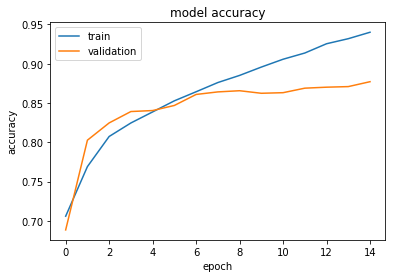

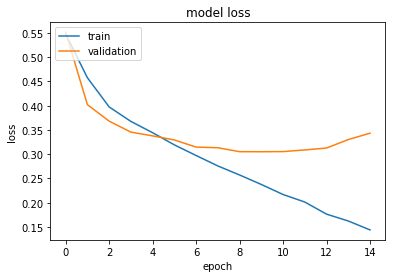

In [12]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import GRU, Bidirectional
from keras.layers.core import Dropout
from keras.layers.core import Masking
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import keras
from keras.layers import multiply

from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Masking


def _build_model(config):
    input1 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q1_in')
    #mask1 = Masking(mask_value=0.0)(input1)
    mask1 = input1
    lstm1 = LSTM(128, activation="relu")(mask1)
    lstm11 = LSTM(128,dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'], 
                  activation="relu",return_sequences=True)(mask1)
    lstm11 = keras.layers.Flatten()(lstm11)
    
    input2 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q2_in')
    #mask2 = Masking(mask_value=0.0)(input2)
    mask2 = input2
    lstm2 = LSTM(128,activation="relu")(mask2)
    lstm22 = LSTM(128,dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'], 
                  activation="relu", return_sequences=True)(mask2)
    lstm22 = keras.layers.Flatten()(lstm22)
    
    concatenate = keras.layers.concatenate([lstm1, lstm11, lstm2, lstm22], axis=-1)
    
    output = Dense(1, activation='sigmoid', name='output')(concatenate)
    model = Model(inputs=[input1, input2], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy', du.f1, du.recall, du.precision])
    model.summary()
    plot_model(model, show_shapes=True, to_file='models/model.png')
    return model

def _build_model_old(config):
    drop_rate = 0.3
    
    shared_lstm1 = keras.layers.Bidirectional(LSTM(128), merge_mode='concat', weights=None)
    shared_lstm2 = keras.layers.Bidirectional(LSTM(128), merge_mode='concat', weights=None)
    
    input1 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q1_in')
    mask1 = Masking(mask_value=0.0)(input1)
    # Passing through the 1st shared lstm
    # This time shared_lstm1 learns on q1_in
    x1 = shared_lstm1(mask1)
    
    input2 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q2_in')
    mask2 = Masking(mask_value=0.0)(input2)
    
    # This time shared_lstm1 learns on q2_in
    x2 = shared_lstm1(mask2)
    
    # Passing through 2nd shared lstm
    # This time shared_lstm2 learns on q2_in, and then on q1_in
    x22 = shared_lstm2(mask2)
    x11 = shared_lstm2(mask1)
    
    # Equivalent to subtracted = keras.layers.subtract([x1, x2])
    subtracted = keras.layers.Subtract()([x1, x2])
    subtracted = multiply([subtracted, subtracted])
    
    mult = multiply([x1, x2])
    #dotProduct = keras.layers.dot([x1, x2], axes = -1,  normalize=False)
    
    
    subtracted2 = keras.layers.Subtract()([x11, x22])
    subtracted2 = multiply([subtracted2, subtracted2])
    
    mult2 = multiply([x11, x22])
    #dotProduct2 = keras.layers.dot([x11, x22], axes = -1,  normalize=False)
    
    diffSubtracted = keras.layers.Subtract()([subtracted, subtracted2])
    diffSubtractedMult =  multiply([diffSubtracted, diffSubtracted])
    subtractMult = multiply([subtracted, subtracted2])
    
    concatenate = keras.layers.concatenate([x1,x2, subtracted, mult,# diffSubtracted, diffSubtractedMult, subtractMult, 
                                            subtracted2, mult2, x22, x11], axis=-1)
    concatenate = Dropout(drop_rate)(concatenate)
    #concatenate = keras.layers.concatenate([x1,x2], axis=-1)
    
    dense1 = Dense(256, activation='relu', name='dense1')(concatenate)
    dense1 = Dropout(drop_rate)(dense1)
    
    dense2 = Dense(128, activation='relu', name='dense2')(dense1)
    dense2 = Dropout(drop_rate)(dense2)
    
    output = Dense(1, activation='sigmoid', name='output')(dense2)
    with tf.device('/cpu:0'):
        model = Model(inputs=[input1, input2], outputs=[output])
    
    parallel_model = multi_gpu_model(model, gpus=2)
    optimizer = keras.optimizers.Nadam()
    #optimizer = keras.optimizers.Adam()
    parallel_model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=['accuracy', du.f1, du.recall, du.precision])
    parallel_model.summary()
    plot_model(parallel_model, show_shapes=True, to_file='models/model.png')
    return parallel_model


def _build_non_shared_lstm_model(config):
    lstm1 = keras.layers.Bidirectional(LSTM(128), merge_mode='concat', weights=None)
    
    input1 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q1_in')
    mask1 = Masking(mask_value=0.0)(input1)
    x1 = lstm1(mask1)
    
    drop_rate = 0.3
    
    #x1 = Dropout(drop_rate)(x1)
    
    input2 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q2_in')
    mask2 = Masking(mask_value=0.0)(input2)
    lstm2 = keras.layers.Bidirectional(LSTM(128), merge_mode='concat', weights=None)
    x2 = lstm2(mask2)
    
    #x2 = Dropout(drop_rate)(x2)
    
    # Equivalent to subtracted = keras.layers.subtract([x1, x2])
    subtracted = keras.layers.Subtract()([x1, x2])
    subtracted = multiply([subtracted, subtracted])
    
    mult = multiply([x1, x2])
    

    concatenate = keras.layers.concatenate([x1,x2, subtracted, mult], axis=-1)
    concatenate = Dropout(drop_rate)(concatenate)
       
    #concatenate = keras.layers.concatenate([x1,x2], axis=-1)
    dense1 = Dense(256, activation='relu', name='dense1')(concatenate)
    dense1 = Dropout(drop_rate)(dense1)
    
    dense2 = Dense(128, activation='relu', name='dense2')(dense1)
    dense2 = Dropout(drop_rate)(dense2)
    
    output = Dense(1, activation='sigmoid', name='output')(dense2)
    model = Model(inputs=[input1, input2], outputs=[output])
    optimizer = keras.optimizers.Nadam() # 'adam'
    #optimizer = keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=['accuracy', du.f1, du.recall, du.precision])
    model.summary()
    plot_model(model, to_file='models/model.png')
    return model


def _build_shared_lstm_model(config):
    shared_lstm1 = keras.layers.Bidirectional(LSTM(128), merge_mode='concat', weights=None)
    
    input1 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q1_in')
    mask1 = Masking(mask_value=0.0)(input1)
    x1 = shared_lstm1(mask1)
    
    drop_rate = 0.3
    
    #x1 = Dropout(drop_rate)(x1)
    
    input2 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q2_in')
    mask2 = Masking(mask_value=0.0)(input2)
    x2 = shared_lstm1(mask2)
    
    #x2 = Dropout(drop_rate)(x2)
    
    # Equivalent to subtracted = keras.layers.subtract([x1, x2])
    subtracted = keras.layers.Subtract()([x1, x2])
    subtracted = multiply([subtracted, subtracted])
    
    mult = multiply([x1, x2])
    

    concatenate = keras.layers.concatenate([x1,x2, subtracted, mult], axis=-1)
    concatenate = Dropout(drop_rate)(concatenate)
       
    #concatenate = keras.layers.concatenate([x1,x2], axis=-1)
    dense1 = Dense(256, activation='relu', name='dense1')(concatenate)
    dense1 = Dropout(drop_rate)(dense1)
    
    dense2 = Dense(128, activation='relu', name='dense2')(dense1)
    dense2 = Dropout(drop_rate)(dense2)
    
    output = Dense(1, activation='sigmoid', name='output')(dense2)
    model = Model(inputs=[input1, input2], outputs=[output])
    optimizer = keras.optimizers.Nadam() # 'adam'
    #optimizer = keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=['accuracy', du.f1, du.recall, du.precision])
    model.summary()
    plot_model(model, to_file='models/model.png')
    return model


def train_model():
    #config = du.get_config(train_dataset_path, test_size=test_size, val_size=val_size)
    start = time.time()
    #df_train_q1_emb,df_train_q2_emb, df_train_label  = du.load_dataset(trainDataset,w2v,config)
    #df_val_q1_emb,df_val_q2_emb, df_val_label  = du.load_dataset(valDataset,w2v, config)
    end = time.time()
    print("Total time passed", (end - start))
    print("df_train_q1_emb.shape",df_train_q1_emb_limit.shape)
    print("df_train_q2_emb.shape", df_train_q2_emb_limit.shape)
    print("df_train_label.shape", df_train_label_limit.shape)
    
    print("df_val_q1_emb.shape",df_val_q1_emb_limit.shape)
    print("df_val_q2_emb.shape", df_val_q2_emb_limit.shape)
    print("df_val_label.shape", df_val_label_limit.shape)
    
    #model = _build_model(config)
    model = _build_model_old(config)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.8, 
                                  patience=2, 
                                  #min_lr=0.000001,
                                  verbose=1)
    
    #filepath="model/adidas-may-29.h5"
    #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)#10
    callback_list = [reduce_lr, early_stopping] # , early_stopping
    #config['nb_epochs'] = 10
    history = model.fit(x=[df_train_q1_emb_limit, df_train_q2_emb_limit],
                  y=df_train_label_limit, 
                  batch_size=config['batch_size'], 
                  epochs=config['nb_epochs'], 
                  verbose=1, 
                  validation_data = ([df_val_q1_emb_limit,df_val_q2_emb_limit], df_val_label_limit),
                  callbacks=callback_list)#
    return (history,model)

start = time.time()
config = du.get_config(train_dataset_path, test_size=test_size, val_size=val_size, embedding_dimension=emb_dim)
history, model = train_model() 
end = time.time()
print("Total time", (end - start))
du.plot_model_accuracy(history,modelDir="models/", hasF1=True)

# Evaluate on test dataset

In [13]:
import json

df_test_q1_emb, df_test_q2_emb, df_test_label  = du.load_dataset(testDataset,w2v, config)


print("df_test_q1_emb.shape",df_test_q1_emb.shape)
print("df_test_q2_emb.shape", df_test_q2_emb.shape)
print("df_test_label.shape", df_test_label.shape)

result = model.evaluate(x=[df_test_q1_emb, df_test_q2_emb], y=df_test_label)
metrc_names = model.metrics_names
result = {k:v for k,v in zip(metrc_names, result)}


result = json.dumps(result, sort_keys=True, indent=4)
print("\n Test results \n")
print(result)

df_test_q1_emb.shape (4043, 32, 300)
df_test_q2_emb.shape (4043, 32, 300)
df_test_label.shape (4043,)
4043/4043 [==============================] - 18s 4ms/step

 Test results 

{
    "acc": 0.8686618848127685,
    "f1": 0.8106572700850067,
    "loss": 0.3971213897413291,
    "precision": 0.8208242591406902,
    "recall": 0.8165945998519003
}
